In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prime-trade-ai-task/historical_data.csv
/kaggle/input/prime-trade-ai-task/fear_greed_index.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
trades_df = pd.read_csv('/kaggle/input/prime-trade-ai-task/historical_data.csv')
sentiment_df = pd.read_csv('/kaggle/input/prime-trade-ai-task/fear_greed_index.csv')

In [5]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [6]:
trades_df['Datetime'] = pd.to_datetime(trades_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades_df['date'] = trades_df['Datetime'].dt.normalize()

In [7]:
merged_df = pd.merge(
    trades_df, 
    sentiment_df[['date', 'value', 'classification']], 
    on='date', 
    how='left'
)

In [8]:
merged_df.rename(columns={'value': 'Sentiment_Score', 'classification': 'Sentiment_Class'}, inplace=True)

In [9]:
merged_df.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
Datetime            0
date                0
Sentiment_Score     6
Sentiment_Class     6
dtype: int64

In [10]:
merged_df['Is_Win'] = (merged_df['Closed PnL'] > 0).astype(int)
merged_df['Is_Loss'] = (merged_df['Closed PnL'] < 0).astype(int)

In [11]:
daily_trader_stats = merged_df.groupby(['Account', 'date']).agg(
    total_trades=('Order ID', 'count'),
    avg_trade_size_usd=('Size USD', 'mean'),
    max_trade_size_usd=('Size USD', 'max'), # Proxy for checking if they took massive leverage/risk
    daily_gross_pnl=('Closed PnL', 'sum'),
    total_fees=('Fee', 'sum'),
    long_trades=('Side', lambda x: (x.str.upper() == 'BUY').sum()),
    short_trades=('Side', lambda x: (x.str.upper() == 'SELL').sum()),
    winning_trades=('Is_Win', 'sum'),
    losing_trades=('Is_Loss', 'sum'),
    sentiment_score=('Sentiment_Score', 'first'),
    sentiment_class=('Sentiment_Class', 'first')
).reset_index()

In [12]:
daily_trader_stats['net_pnl'] = daily_trader_stats['daily_gross_pnl'] - daily_trader_stats['total_fees']

In [13]:
total_closed_trades = daily_trader_stats['winning_trades'] + daily_trader_stats['losing_trades']
daily_trader_stats['win_rate'] = (daily_trader_stats['winning_trades'] / total_closed_trades.replace(0, np.nan)) * 100

In [14]:
daily_trader_stats['long_short_ratio'] = daily_trader_stats['long_trades'] / daily_trader_stats['short_trades'].replace(0, np.nan)

In [15]:
def group_sentiment(x):
    if pd.isna(x): return 'Neutral'
    if 'Greed' in str(x): return 'Greed'
    if 'Fear' in str(x): return 'Fear'
    return 'Neutral'

daily_trader_stats['Sentiment_Group'] = daily_trader_stats['sentiment_class'].apply(group_sentiment)
df_analysis = daily_trader_stats[daily_trader_stats['Sentiment_Group'].isin(['Fear', 'Greed'])].copy()

In [16]:
median_trades = df_analysis['total_trades'].median()
df_analysis['Trader_Type'] = df_analysis['total_trades'].apply(
    lambda x: 'Frequent (Day Trader)' if x > median_trades else 'Infrequent (Swing/Hold)'
)
median_size = df_analysis['avg_trade_size_usd'].median()
df_analysis['Risk_Profile'] = df_analysis['avg_trade_size_usd'].apply(
    lambda x: 'High Volume (High Risk)' if x > median_size else 'Low Volume (Low Risk)'
)

In [17]:
print(daily_trader_stats.head())

                                      Account       date  total_trades  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11           177   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17            68   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18            40   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22            12   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26            27   

   avg_trade_size_usd  max_trade_size_usd  daily_gross_pnl  total_fees  \
0         5089.718249            59999.96              0.0  167.796055   
1         7976.664412            65882.09              0.0   67.883615   
2        23734.500000           665771.71              0.0   94.937983   
3        28186.666667            78852.88         -21227.0   33.823995   
4        17248.148148           132297.77           1603.1  104.622490   

   long_trades  short_trades  winning_trades  losing_trades  sentiment_score  \
0            0           177  

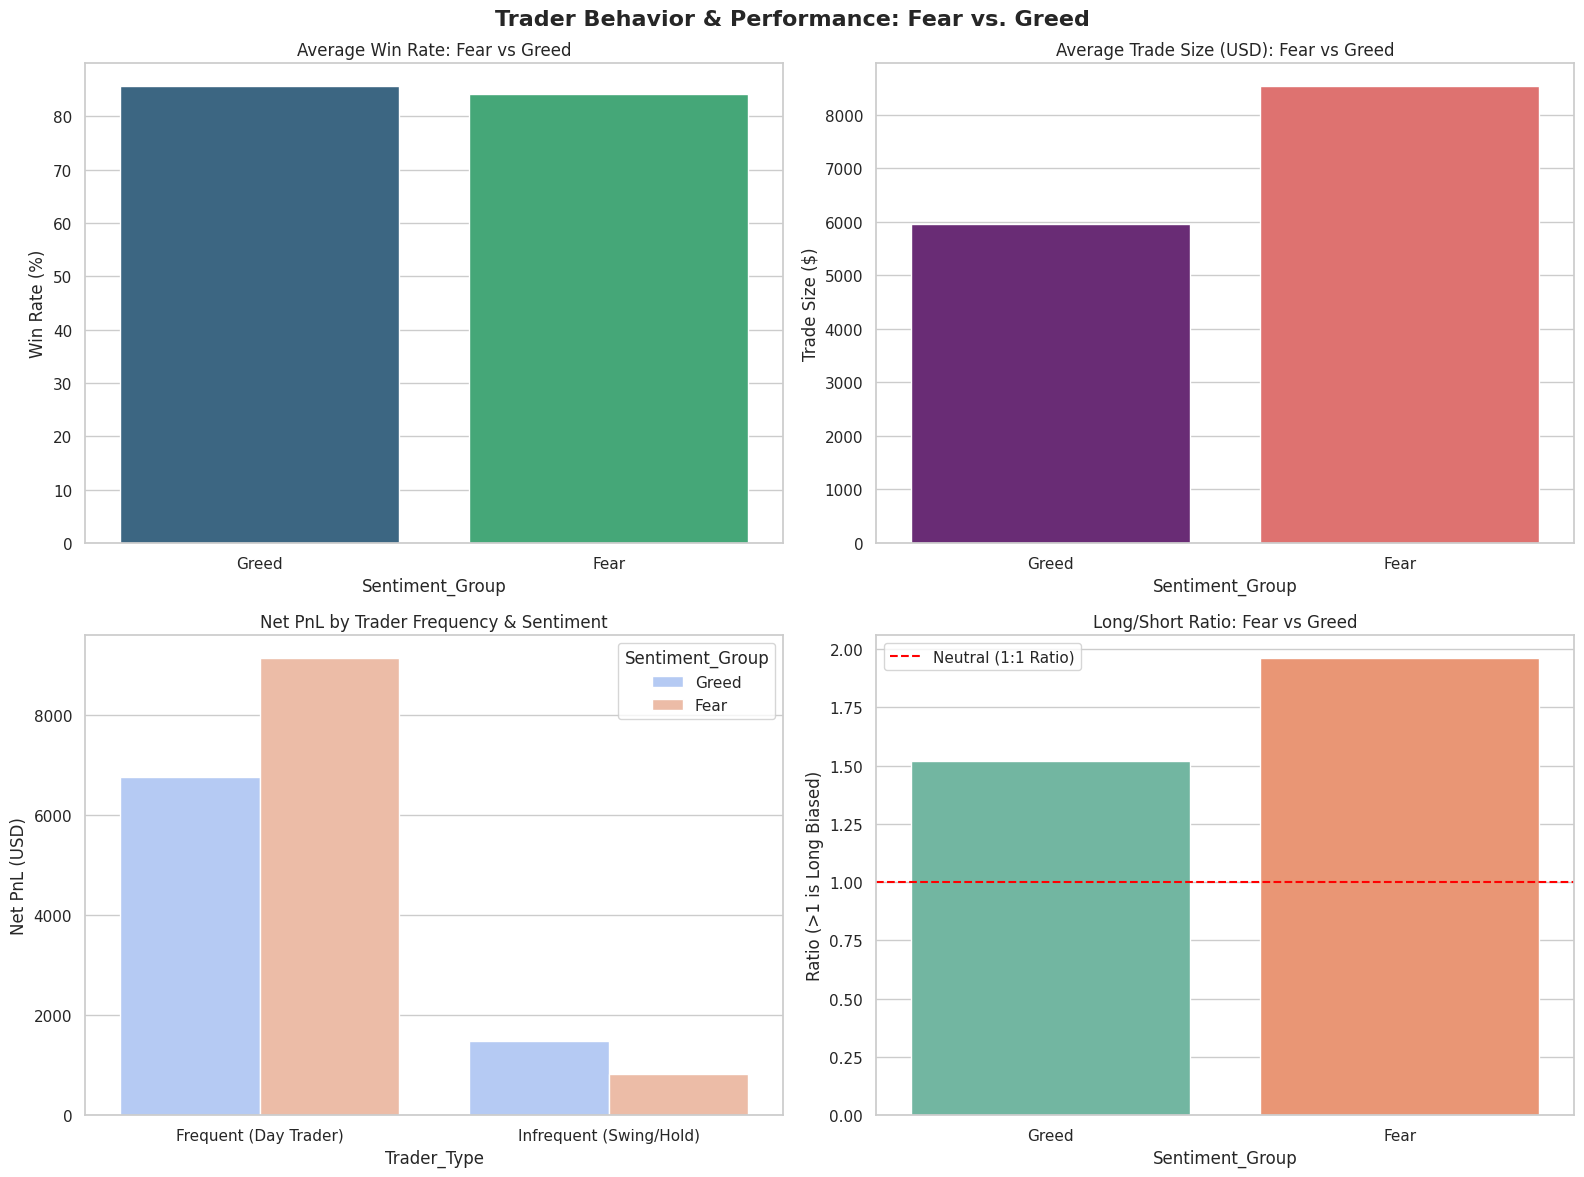

In [18]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Trader Behavior & Performance: Fear vs. Greed", fontsize=16, fontweight='bold')

sns.barplot(data=df_analysis, x='Sentiment_Group', y='win_rate', ax=axes[0, 0], errorbar=None, palette='viridis')
axes[0, 0].set_title('Average Win Rate: Fear vs Greed')
axes[0, 0].set_ylabel('Win Rate (%)')

sns.barplot(data=df_analysis, x='Sentiment_Group', y='avg_trade_size_usd', ax=axes[0, 1], errorbar=None, palette='magma')
axes[0, 1].set_title('Average Trade Size (USD): Fear vs Greed')
axes[0, 1].set_ylabel('Trade Size ($)')

sns.barplot(data=df_analysis, x='Trader_Type', y='net_pnl', hue='Sentiment_Group', ax=axes[1, 0], errorbar=None, palette='coolwarm')
axes[1, 0].set_title('Net PnL by Trader Frequency & Sentiment')
axes[1, 0].set_ylabel('Net PnL (USD)')

df_analysis['long_short_ratio_plot'] = df_analysis['long_short_ratio'].fillna(1) # 1 means equal longs and shorts
sns.barplot(data=df_analysis, x='Sentiment_Group', y='long_short_ratio_plot', ax=axes[1, 1], errorbar=None, palette='Set2')
axes[1, 1].axhline(1.0, color='red', linestyle='--', label='Neutral (1:1 Ratio)')
axes[1, 1].set_title('Long/Short Ratio: Fear vs Greed')
axes[1, 1].set_ylabel('Ratio (>1 is Long Biased)')
axes[1, 1].legend()
plt.tight_layout()
plt.show()

In [19]:
df_ml = daily_trader_stats.sort_values(by=['Account', 'date']).copy()
df_ml['next_day_pnl'] = df_ml.groupby('Account')['net_pnl'].shift(-1)
df_ml['target_is_profitable'] = (df_ml['next_day_pnl'] > 0).astype(int)
df_ml = df_ml.dropna(subset=['next_day_pnl']).copy()

In [20]:
features = ['total_trades', 'avg_trade_size_usd', 'long_short_ratio', 'sentiment_score']
df_ml['long_short_ratio'] = df_ml['long_short_ratio'].fillna(1.0) # 1.0 represents neutral bias
df_ml['sentiment_score'] = df_ml['sentiment_score'].fillna(df_ml['sentiment_score'].median())

In [21]:
X = df_ml[features]
y = df_ml['target_is_profitable']

split_idx = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, class_weight='balanced')

In [23]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [24]:
predictions = model.predict(X_test)

In [25]:
print(f"Overall Accuracy: {accuracy_score(y_test, predictions):.2f}")
print("\nClassification Report:\n", classification_report(y_test, predictions))

Overall Accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.57      0.56       194
           1       0.68      0.66      0.67       268

    accuracy                           0.62       462
   macro avg       0.61      0.62      0.62       462
weighted avg       0.63      0.62      0.62       462



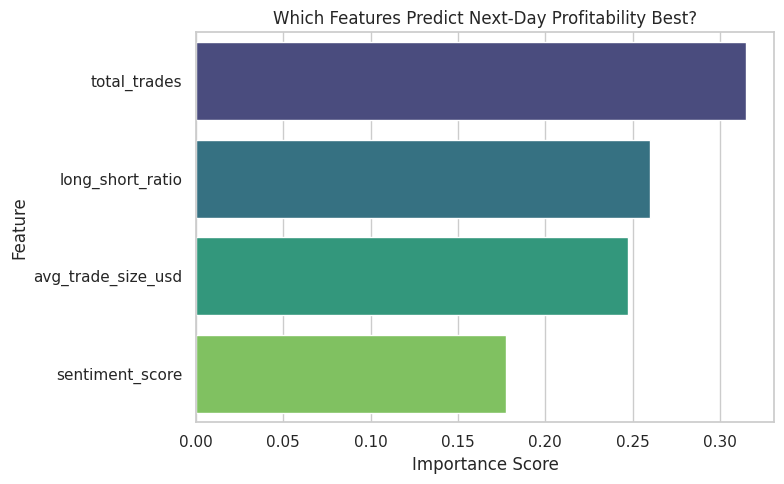

In [26]:
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Which Features Predict Next-Day Profitability Best?')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [27]:
cluster_features = ['total_trades', 'avg_trade_size_usd', 'long_short_ratio']
trader_profiles = daily_trader_stats.groupby('Account')[cluster_features].mean().reset_index()
trader_profiles['long_short_ratio'] = trader_profiles['long_short_ratio'].fillna(1.0) 

In [28]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_profiles[cluster_features])

In [29]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

In [30]:
trader_profiles['Cluster'] = kmeans.fit_predict(scaled_features)

In [31]:
archetypes = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cluster_features)
archetypes.index.name = 'Cluster'
print("--- Behavioral Archetype Centers ---")
print(archetypes.round(2).to_markdown())

--- Behavioral Archetype Centers ---
|   Cluster |   total_trades |   avg_trade_size_usd |   long_short_ratio |
|----------:|---------------:|---------------------:|-------------------:|
|         0 |          47.47 |              4857.29 |               1.14 |
|         1 |         143.16 |             26905.5  |               1.61 |
|         2 |         276.75 |              7211.36 |               3.98 |


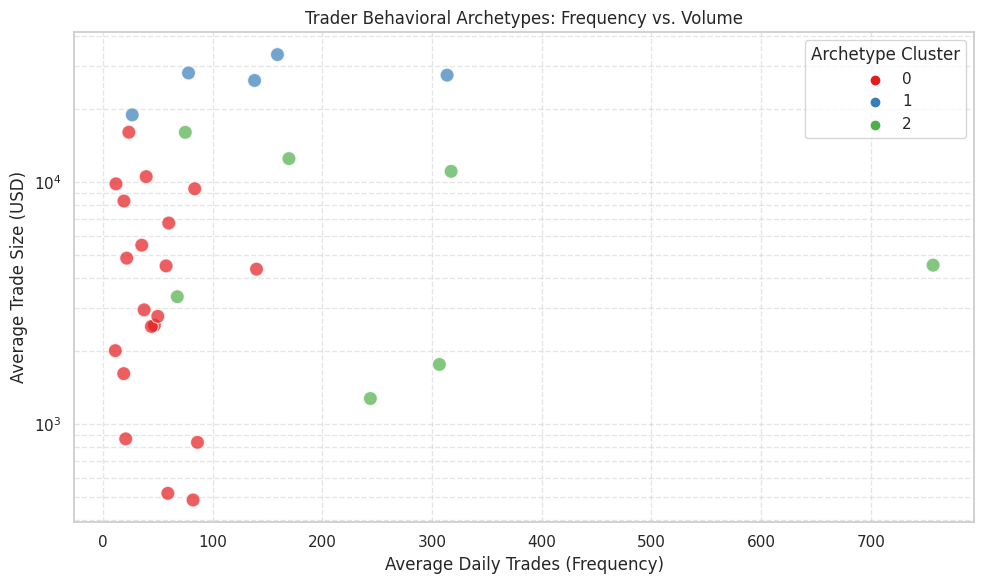

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=trader_profiles, 
    x='total_trades', 
    y='avg_trade_size_usd', 
    hue='Cluster', 
    palette='Set1', 
    s=100, 
    alpha=0.7
)

plt.title('Trader Behavioral Archetypes: Frequency vs. Volume')
plt.xlabel('Average Daily Trades (Frequency)')
plt.ylabel('Average Trade Size (USD)')
plt.yscale('log') # Log scale helps visualize large differences in USD volume
plt.legend(title='Archetype Cluster')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [33]:
# Merge the clusters back into our main dataset so we can see which cluster is most profitable
trader_profiles_merged = pd.merge(trader_profiles[['Account', 'Cluster']], daily_trader_stats, on='Account', how='left')
cluster_performance = trader_profiles_merged.groupby('Cluster')[['net_pnl', 'win_rate']].mean().round(2)
print("\n--- Average Performance by Archetype ---")
print(cluster_performance.to_markdown())


--- Average Performance by Archetype ---
|   Cluster |   net_pnl |   win_rate |
|----------:|----------:|-----------:|
|         0 |   2742.82 |      84.14 |
|         1 |  14542    |      84.11 |
|         2 |   6452.01 |      87.06 |


In [34]:
daily_trader_stats.to_csv('daily_trader_stats.csv', index=False)
trader_profiles_merged.to_csv('trader_profiles.csv', index=False)